## Collecting and Analyzing Multidimensional Data with Local Differential Privacy

## 一、背景简介

### 1.问题描述

首先考虑一维属性的情况，对于$n$个用户，每个用户对应于一个值$t_{i}(1\leq i \leq n) \in [-1, 1]$，期望通过基于LDP的方式估计所有用户有关$t_{i}$的均值。

### 2.LDP定义

<img src="images/LDP_define.png" height="400" width="400" style="float:left" >

## 二、目前存在的解决方式

### 1.Laplace 机制

扰动方式：  $t_{i}^{*} = t_{i} + Lap(\frac{2}{\epsilon})$ 。其中$Lap(\lambda)$为拉普拉斯噪声，概率密度函数为：$f(x)=\frac{1}{2\lambda} exp (-\frac{|x|}{\lambda})$。

由于噪声的均值为0，因此$E[t_{i}^{*}] = t_{i}$，即最终的统计结果为无偏估计。

方差为：$Var[t_{i}^{*}] = \frac{8}{\epsilon ^{2}}$

### 2.Duchi的方案

2.1 扰动方式

<img src="images/Duchi.png" height="400" width="400" style="float:left" >

2.2 满足$\epsilon-$LDP

$$\frac{Pr[f(t_{i})=t_{i}^{*}]}{Pr[f(t_{i}^{'})=t_{i}^{*}]}=\frac{(e^{\epsilon} - 1)t_{i} + (e^{\epsilon} + 1)}{(e^{\epsilon} - 1)t_{i}^{'} + (e^{\epsilon} + 1)} \leq \frac{(e^{\epsilon} - 1)*1 + (e^{\epsilon} + 1)}{(e^{\epsilon} - 1)*(-1) + (e^{\epsilon} + 1)}=e^{\epsilon}$$

2.3 无偏估计

$$E[t_{i}^{*}]=(\frac{e^{\epsilon}-1}{2e^{\epsilon}+2}t_{i} + \frac{1}{2})(\frac{e^{\epsilon}+1}{e^{\epsilon}-1}) + (1 - \frac{e^{\epsilon}-1}{2e^{\epsilon}+2}t_{i} - \frac{1}{2})(- \frac{e^{\epsilon}+1}{e^{\epsilon}-1})=t_{i} $$

2.4 方差

$$Var[t_{i}^{*}]=E[(t_{i}^{*})^{2}]- E[t_{i}^{*}]^{2}=(\frac{e^{\epsilon}-1}{2e^{\epsilon}+2}t_{i} + \frac{1}{2})(\frac{e^{\epsilon}+1}{e^{\epsilon}-1})^{2} + (1 - \frac{e^{\epsilon}-1}{2e^{\epsilon}+2}t_{i} - \frac{1}{2})(- \frac{e^{\epsilon}+1}{e^{\epsilon}-1})^{2} - t_{i}^{2}=(\frac{e^{\epsilon}+1}{e^{\epsilon}-1})^{2} - t_{i}^{2} \leq (\frac{e^{\epsilon}+1}{e^{\epsilon}-1})^{2}$$

### 3.存在的问题

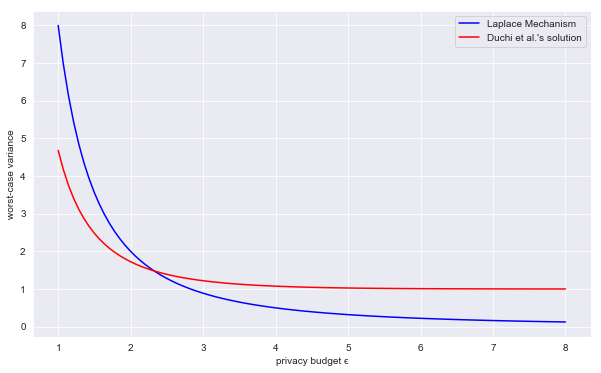

In [1]:
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt


# 忽略一些warning
warnings.filterwarnings('ignore')
%matplotlib inline

def var_Lap(epsilon):
    return 8/(epsilon**2)

def var_Duchi(epsilon) :
    return ((np.e ** epsilon +1)/(np.e ** epsilon -1))**2

x = np.linspace(1,8,100)
sns.set_style('darkgrid')
plt.figure(1, figsize=(10,6))
plt.plot(x,[var_Lap(i) for i in x],c='blue', label="Laplace Mechanism")
plt.plot(x,[var_Duchi(i) for i in x],c='red', label="Duchi et al.'s solution")
plt.ylabel('worst-case variance')
plt.xlabel('privacy budget ϵ')
plt.legend()

当$\epsilon$较小时，Duchi的方式有较小的方差；但是当$\epsilon$较大时，Duchi方式的方差不会小于1（由于$\frac{e^{\epsilon}+1}{e^{\epsilon}-1} >  1$），而此时Laplace机制有较小的方差。

那么如何设计一种方式，它可以结合Laplace机制和Duchi方式的优势，使其在任意的$\epsilon$下都具有较小的方差。

## 三、论文中的解决方式

### 1. Piecewise Mechanism

1.1 扰动方式

<img src="images/PiecewiseMechanism.png" height="400" width="400" style="float:left" >

则扰动的概率密度函数为：
$ pdf(t_{i}^{*}=x | t_{i})=\begin{cases}
p,\quad if \quad x \in [l(t_{i}), r(t_{i})], \\
\frac{p}{e^{\epsilon}}, \quad if \quad x \in [-C, l(t_{i})] \cup [r(t_{i}),C].
\end{cases}
$

$其中：C=\frac{e^{\epsilon /2} + 1}{e^{\epsilon /2} - 1}，p=\frac{e^{\epsilon}-e^{\epsilon /2}}{2e^{\epsilon /2} + 2}，l(t_{i})=\frac{C+1}{2}t_{i}-\frac{C-1}{2}，r(t_{i})=l(t_{i})+C-1=\frac{C+1}{2}t_{i}+\frac{C-1}{2}$

1.2 满足$\epsilon-$LDP

$$\frac{Pr[f(t_{i})=t_{i}^{*}]}{Pr[f(t_{i}^{'})=t_{i}^{*}]}  = \frac{pdf(t_{i}^{*}=x | t_{i})} {pdf(t_{i}^{*}=x | t_{i}^{'})} \leq \frac{p}{p/e^{\epsilon}}=e^{\epsilon}$$

1.3 无偏估计

$E[t_{i}^{*}] = \int_{-C}^{l(t_{i})} \frac{px}{e^{\epsilon}}dx  + \int_{C}^{r(t_{i})} \frac{px}{e^{\epsilon}}dx + \int_{r(t_{i})}^{l(t_{i})} pxdx=\frac{p}{2 e ^{\epsilon}}[l^{2}(t_{i}) -r^{2}(t_{i})] + \frac{p}{2}[r^{2}(t_{i}) -l^{2}(t_{i})]=\frac{p}{2}(1-\frac{1}{e^{\epsilon}})(C-1)(C+1)t_{i}=t_{i}$

1.4 方差

$Var[t_{i}^{*}] = E[(t_{i}^{*})^2] - E[t_{i}^{*}]^{2} = \int_{-C}^{l(t_{i})} \frac{px^{2}}{e^{\epsilon}}dx  + \int_{C}^{r(t_{i})} \frac{px^{2}}{e^{\epsilon}}dx + \int_{r(t_{i})}^{l(t_{i})} px^{2}dx - t_{i}^{2}=\frac{t_{i}^{2}}{e^{\epsilon /2} - 1}+\frac{e^{\epsilon /2} + 3}{3(e^{\epsilon /2} - 1)^2} \leq \frac{1}{e^{\epsilon /2} - 1}+\frac{e^{\epsilon /2} + 3}{3(e^{\epsilon /2} - 1)^2} =  \frac{4e^{\epsilon /2}}{3(e^{\epsilon /2} - 1)^2}$

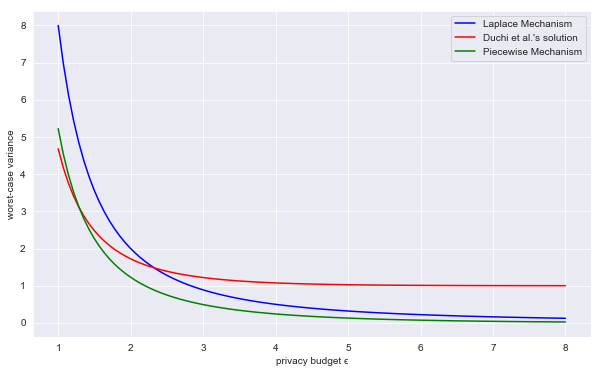

In [3]:
def var_Piecewise(epsilon) :
    return ((4* (np.e ** (epsilon/2)))/(3*(((np.e ** (epsilon/2)) - 1))**2))

x = np.linspace(1,8,100)
sns.set_style('darkgrid')
plt.figure(1, figsize=(10,6))
plt.plot(x,[var_Lap(i) for i in x],c='blue', label="Laplace Mechanism")
plt.plot(x,[var_Duchi(i) for i in x],c='red', label="Duchi et al.'s solution")
plt.plot(x,[var_Piecewise(i) for i in x],c='green', label="Piecewise Mechanism")
plt.ylabel('worst-case variance')
plt.xlabel('privacy budget ϵ')
plt.legend()

### 2.Hybrid Mechanism

2.1 扰动方式

<img src="images/HybridMechanism.png" height="400" width="400" style="float:left" >

2.2 方差

<img src="images/Hvar1.png" height="400" width="400" style="float:left" >

<img src="images/Hvar2.png" height="400" width="400" style="float:left" >

由于：

<img src="images/Hvar3.png" height="400" width="400" style="float:left" >

其中：

<img src="images/Hvar4.png" height="400" width="400" style="float:left" >

证：

令$t=e^{\epsilon /2}$，则$原式=\frac{t+3}{3(t-1)^{2}} - (\frac{t^{2}+1}{t^{2}-1})^{2}=\frac{(t+3)(t+1)^{2} - 3(t^{2}+1)^{2}}{3(t-1)^{2}(t+1)^{2}}=\frac{t}{3(t-1)^{2}(t+1)^{2}} (-3t^{3}+t^2-t+7)$

因此，HM的最差情况下的噪声方差为：

<img src="images/Hvar5.png" height="400" width="400" style="float:left" >

此时，$\alpha$的范围为：

<img src="images/Hvar6.png" height="200" width="200" style="float:left" >

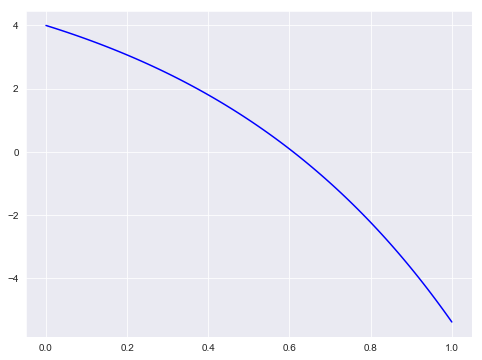

In [4]:
x = np.linspace(0,1,100)
def f(x) :
    t = np.e ** (x/2)
    return   -3*(t**3) + (t**2) -t +7
sns.set_style('darkgrid')
plt.figure(1, figsize=(8,6))
plt.plot(x,[f(i) for i in x],c='blue')

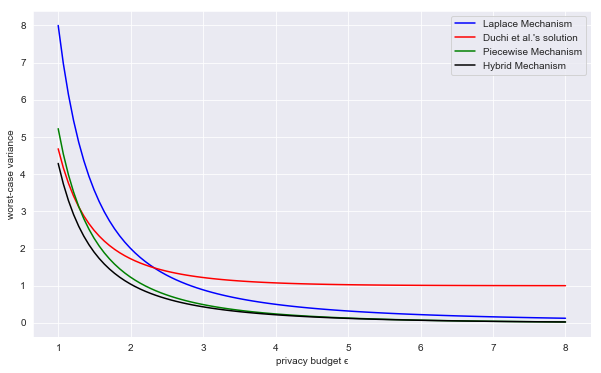

In [6]:
def var_Hybrid(epsilon) :
    return (((np.e **(epsilon/2))+3)/(3*(np.e **(epsilon/2)) * ((np.e ** (epsilon/2))-1))) + ((((np.e ** epsilon)+1)**2)/((np.e **(epsilon/2))* (((np.e ** epsilon)-1)**2)))

x = np.linspace(1,8,100)
sns.set_style('darkgrid')
plt.figure(1, figsize=(10,6))
plt.plot(x,[var_Lap(i) for i in x],c='blue', label="Laplace Mechanism")
plt.plot(x,[var_Duchi(i) for i in x],c='red', label="Duchi et al.'s solution")
plt.plot(x,[var_Piecewise(i) for i in x],c='green', label="Piecewise Mechanism")
plt.plot(x,[var_Hybrid(i) for i in x],c='black', label="Hybrid Mechanism")
plt.ylabel('worst-case variance')
plt.xlabel('privacy budget ϵ')
plt.legend()

### 四、MULTIPLE ATTRIBUTES

### 1 Duchi

#### 1.1 扰动方式

<img src="images/Duchi_MA.png" height="400" width="400" style="float:left" >

#### 1.2 满足$\epsilon-$LDP

$$\frac{Pr[f(t_{i})=t^{*}]}{Pr[f(t_{i}^{'})=t^{*}]} \leq \frac{\frac{e^{\epsilon}}{e^{\epsilon}+1}}{1-\frac{e^{\epsilon}}{e^{\epsilon}+1}} =e^{\epsilon}$$

#### 1.3 无偏估计

$E[T] = E[\frac{e^{\epsilon}}{e^{\epsilon}+1} * T^{+} + \frac{1}{e^{\epsilon}+1} * T^{-}]=E[B]=E[v]=E[(\frac{1}{2} + \frac{1}{2}t_{i}[A_{j}])*1 + (\frac{1}{2} - \frac{1}{2}t_{i}[A_{j}])*(-1)] = E[t_{i}[A_{j}]]$

### 2. PM or HM

Duchi 对于多维属性处理的方式一方面过于复杂，另外一方面无法处理包含数值属性和类别属性的情况。

#### 2.1 扰动方式

<img src="images/PM_HM_MA.png" height="400" width="400" style="float:left" >

其中：$k=\max \{1, min\{d, \lfloor \frac{\epsilon}{2.5} \rfloor \}  \}$

从d维属性中随机选取k个属性的目的是将每个属性的隐私预算从$\frac{\epsilon}{d}$提升为$\frac{\epsilon}{k}$，从而节省隐私预算。

#### 2.2 无偏估计

$E[t_{i}^{*}[A_{j}]]=E[\frac{d}{k}x_{i,j}] = \frac{d}{k}E[x_{i,j}] = \frac{d}{k} * \frac{k}{d}E[t_{i}[A_{j}]]= E[t_{i}[A_{j}]]$

#### 2.3 方差

<img src="images/M_var.png" height="400" width="400" style="float:left" >

其中，使用PM时：

<img src="images/M_var2.png" height="400" width="400" style="float:left" >

使用HM时：

<img src="images/M_var3.png" height="400" width="400" style="float:left" >

因此，PM的方差为：

<img src="images/M_PMvar.png" height="400" width="400" style="float:left" >

HM的方差为：

<img src="images/M_HMvar.png" height="400" width="400" style="float:left" >

### 3. 处理数值属性与类别属性共同出现的场景

论文中的方法是基于现有的方式（如OLH），分情况进行扰动：

<img src="images/numerical_categorical.png" height="400" width="400" style="float:left" >

### 五、SGD with LDP

将梯度作为用户属性，使用PM或HM机制来估计梯度的均值。

<img src="images/SGD_LDP.png" height="300" width="300" >

## 问题：

离散属性如何通过上述方式实现LDP？

算法三：$t_{*} \cdot v \geq 0(or B)$ ?

算法四：采样方式是否可以改进？

SGD with LDP 优化